In [1]:
import sys
sys.path.append('../src')

from m4_generator import M4Generator
from error_functions import *
from visualization import *
from evaluation import evaluate_model
from m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
EPOCHS = 50
BATCH_SIZE = 200
LOOKBACK = 72
HORIZON = 48
HIDDEN_LAYER_SIZE = 50
LOSS = smapetf

model_name = f'LSTM_E{EPOCHS}_B{BATCH_SIZE}_H{HIDDEN_LAYER_SIZE}_L{LOOKBACK}_ERR(smapetf)'

print(model_name)

gen = M4Generator("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON, BATCH_SIZE)

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
        horizon=HORIZON, learning_rate=0.001, loss = LOSS, dropout_ratio = 0.3)

hist = model.train(gen, epochs=EPOCHS)

#model.save(f'../models/{model_name}.json', f'../models/{model_name}.h5')

LSTM_E50_B200_H50_L72_ERR(smapetf)
Epoch 1/50
22/22 [==============================] - 7s 314ms/step - loss: 83.9050
Epoch 2/50
22/22 [==============================] - 6s 284ms/step - loss: 52.9879
Epoch 3/50
22/22 [==============================] - 6s 284ms/step - loss: 40.7631
Epoch 4/50
22/22 [==============================] - 6s 284ms/step - loss: 32.6027
Epoch 5/50
22/22 [==============================] - 6s 285ms/step - loss: 27.5077
Epoch 6/50
22/22 [==============================] - 6s 283ms/step - loss: 24.7266
Epoch 7/50
22/22 [==============================] - 6s 284ms/step - loss: 22.3203
Epoch 8/50
22/22 [==============================] - 6s 284ms/step - loss: 21.0738
Epoch 9/50
22/22 [==============================] - 6s 285ms/step - loss: 19.6546
Epoch 10/50
22/22 [==============================] - 6s 285ms/step - loss: 18.9412
Epoch 11/50
22/22 [==============================] - 6s 283ms/step - loss: 18.1485
Epoch 12/50
22/22 [==============================] - 6s 283ms

In [3]:
print(model_name)
model.save(f'../models/test.json', f'../models/test.h5')

LSTM_E50_B200_H50_L72_ERR(smapetf)
Saved model to disk


In [4]:

#=================== Evaluate Model
model = M4Model(batch_size=BATCH_SIZE)
model.load('../models/test.json','../models/test.h5')

train_x, train_y, test_x, test_y = gen.get_data()

train_error = evaluate_model(model, train_x, train_y, smapetf)
print(train_error)

test_error = evaluate_model(model, test_x, test_y, smapetf)
print(test_error)


Loaded model from disk


ValueError: operands could not be broadcast together with shapes (200,72) (200,48) 

(414, 48)


ValueError: cannot reshape array of size 19872 into shape (500,48,1)

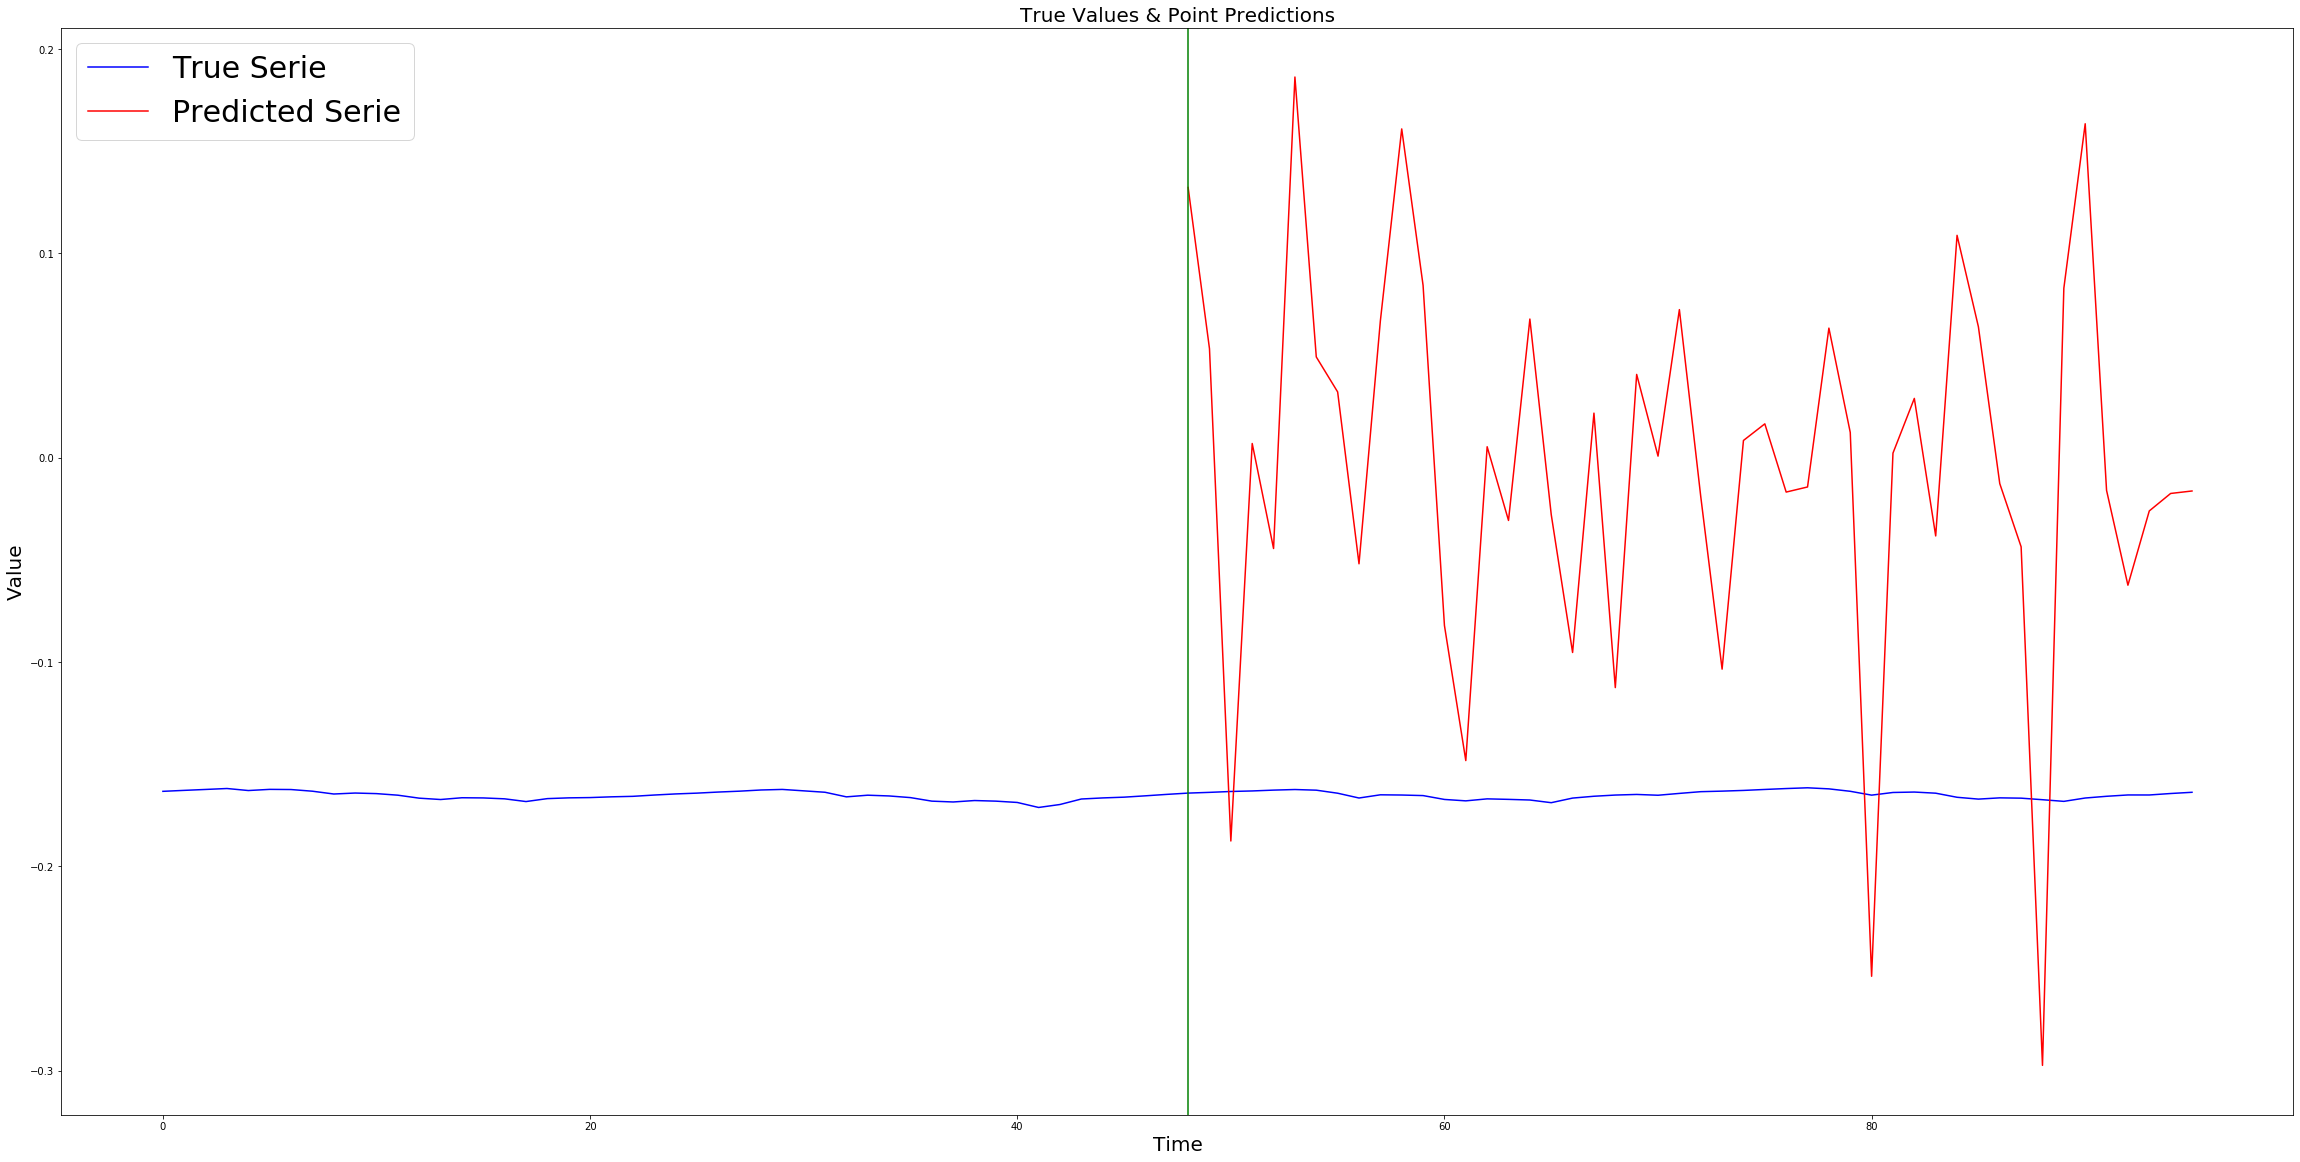

In [10]:
IDX = 9
#============ Predict Train
predictedY = model.predict(train_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1))

#plot_series(train_x, train_y, predictedY, series_num=10)
plot_serie_and_prediction(train_x, train_y, predictedY, serie_indx=IDX)

#============ Predict Test
predictedY = model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1))

#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(test_x, test_y, predictedY, serie_indx=IDX)

In [ ]:
#=================== Evaluate Model
train_x, train_y, test_x, test_y = gen.get_data()

train_error = evaluate_model(model, train_x, train_y, smapetf)
test_error = evaluate_model(model, test_x, test_y, smapetf)

with open(f'models/{model_name}.txt', 'a') as file:
    file.write(f'Training Error: {train_error}\n')
    file.write(f'Test Error: {test_error}')